<h1 align="center"> Modeling </h1>

### Baseline model: Linear Regression

In [85]:
linear_df = df.drop([
    'created_at',
    'actual_delivery_time',
    'store_id',
    'tkt_created_year',
    'tkt_deliver_day','tkt_deliver_time',
    'tkt_deliver_year','total_busy_partners','total_outstanding_orders','creat_day_is_weekend', 'deliver_day_is_wekend','tkt_deliver_month',
],axis=1)

linear_df.sample(3)

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,delivery_duration,tkt_created_month,tkt_create_day,tkt_created_time
2788,1.0,chinese,1.0,3,1100,3,160,710,0.0,81.366667,2,16,20
10248,5.0,mexican,1.0,2,1750,2,655,1095,40.0,65.950000,1,23,2
43103,1.0,other,5.0,2,1014,2,119,895,18.0,37.300000,2,3,20


In [86]:
X = linear_df.drop('delivery_duration',axis=1)
y = linear_df['delivery_duration']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Encoder
encoder = TargetEncoder(verbose=1)
encode_linear_df = encoder.fit_transform(
    X_train[['market_id','store_primary_category','order_protocol','num_distinct_items']],
    y_train)


# Replacing- encoded values
X_train[['market_id','store_primary_category','order_protocol','num_distinct_items']] = encode_linear_df


# Standization
std = StandardScaler()
linear_X_train_processed_df = pd.DataFrame(
      std.fit_transform(X_train),
      columns=X_train.columns
)

linear_X_train_processed_df

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,tkt_created_month,tkt_create_day,tkt_created_time
0,-0.862705,-1.329114,-1.180642,-0.436372,-0.334807,-0.413426,-0.068684,0.252641,-0.299938,-1.367942,1.268637,1.334525
1,-0.238449,-1.476310,0.474940,0.290239,-0.900965,0.197974,-0.931627,-1.564265,-0.691587,0.731025,-0.359758,-0.976817
2,-0.862705,-1.291244,-0.433142,-0.799677,-0.764515,-1.024826,0.256593,-0.870570,0.543613,-1.367942,1.051517,-0.861250
3,-0.238449,-1.254853,1.206595,0.290239,0.559272,-0.413426,0.457500,-0.421285,-1.233870,-1.367942,0.617279,0.872256
4,1.952331,0.222842,1.206595,-0.073067,1.101221,0.197974,0.782778,1.321939,-0.179431,0.731025,0.183040,-0.745683
...,...,...,...,...,...,...,...,...,...,...,...,...
132257,-0.636224,1.762414,1.206595,2.106766,0.905899,2.032174,-0.834044,-0.654913,-0.812095,0.731025,-0.793997,-0.861250
132258,-0.238449,-0.286746,-0.433142,-0.436372,-0.076212,-0.413426,0.313995,0.962511,2.501858,0.731025,-1.011116,-0.745683
132259,-0.205069,0.226191,1.206595,-0.073067,-0.733703,-0.413426,-0.499199,-1.185069,-0.239685,0.731025,-0.685437,-0.514549
132260,-0.636224,-1.476310,0.474940,0.653544,-0.829989,1.420774,-1.084699,-1.276723,-0.932602,0.731025,-0.468318,1.565659


In [87]:
params = {"fit_intercept":[True,False], "positive":[False,True]}
lr = LinearRegression(n_jobs=-1)

In [88]:
models = RandomizedSearchCV(estimator=lr,param_distributions=params,n_jobs=-1, cv = 10,verbose=True,random_state=1,scoring='neg_mean_squared_error')

models.fit(X_train,y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


RandomizedSearchCV(cv=10, estimator=LinearRegression(n_jobs=-1), n_jobs=-1,
                   param_distributions={'fit_intercept': [True, False],
                                        'positive': [False, True]},
                   random_state=1, scoring='neg_mean_squared_error',
                   verbose=True)

In [89]:
print(models.best_estimator_,models.best_score_,models.best_params_)


pd.DataFrame(
    data=[models.cv_results_['mean_test_score'],models.cv_results_['params']]
).T.rename(columns={0:'mean_train_score', 1: 'parameters'})

LinearRegression(n_jobs=-1) -561.4554075932629 {'positive': False, 'fit_intercept': True}


,mean_train_score,parameters
0,-561.455408,"{'positive': False, 'fit_intercept': True}"
1,-564.331354,"{'positive': True, 'fit_intercept': True}"
2,-564.808482,"{'positive': False, 'fit_intercept': False}"
3,-570.172868,"{'positive': True, 'fit_intercept': False}"


In [90]:
lr_model = models.best_estimator_

lr_model.fit(X_train,y_train)

LinearRegression(n_jobs=-1)

In [91]:
X_test[['market_id','store_primary_category','order_protocol','num_distinct_items']] = encoder.transform( X_test[['market_id','store_primary_category','order_protocol','num_distinct_items']])

X_test = pd.DataFrame(
     std.transform(X_test),
    columns=X_train.columns
)
X_test

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,tkt_created_month,tkt_create_day,tkt_created_time
0,-0.636224,-0.159413,0.474940,-0.073067,-0.376072,-0.413426,-1.025384,-0.421285,-0.751841,0.731025,-0.685437,1.565659
1,-0.862705,-1.329114,-1.180642,-0.436372,-0.789824,-0.413426,-0.453278,-0.647725,0.784628,-1.367942,1.160077,-0.861250
2,-0.238449,1.100480,-0.433142,-0.799677,-0.653924,-1.024826,1.548137,0.603083,1.778814,-1.367942,1.485756,-0.630116
3,-0.636224,-1.172764,1.206595,-0.799677,-0.981845,-1.024826,0.407752,-0.468011,-1.263997,0.731025,-0.793997,0.987823
4,-0.039379,-0.047933,-0.232353,-0.436372,3.582633,-0.413426,4.045122,9.409060,-0.992856,-1.367942,1.051517,1.450092
...,...,...,...,...,...,...,...,...,...,...,...,...
65139,-0.862705,-1.329114,1.206595,-0.436372,-0.017890,-0.413426,1.234340,0.308353,-0.330065,0.731025,-0.251199,1.565659
65140,-0.862705,1.273361,-0.433142,-0.436372,0.462986,-0.413426,0.888015,0.612069,-0.360192,0.731025,-1.553915,1.565659
65141,-0.636224,-0.047980,-1.180642,-0.799677,-1.063825,-1.024826,0.122655,-0.735785,0.091711,-1.367942,1.485756,-0.745683
65142,-0.238449,-0.756247,-0.232353,-0.799677,-1.226685,-1.024826,-0.633137,-1.445654,-0.691587,-1.367942,1.485756,-0.976817


In [92]:
y_pred = lr_model.predict(X_test)

In [93]:
residual = y_test-y_pred
print(f"mse: {mean_squared_error(y_true=y_test,y_pred=y_pred)}")

mse: 16930.071423824887


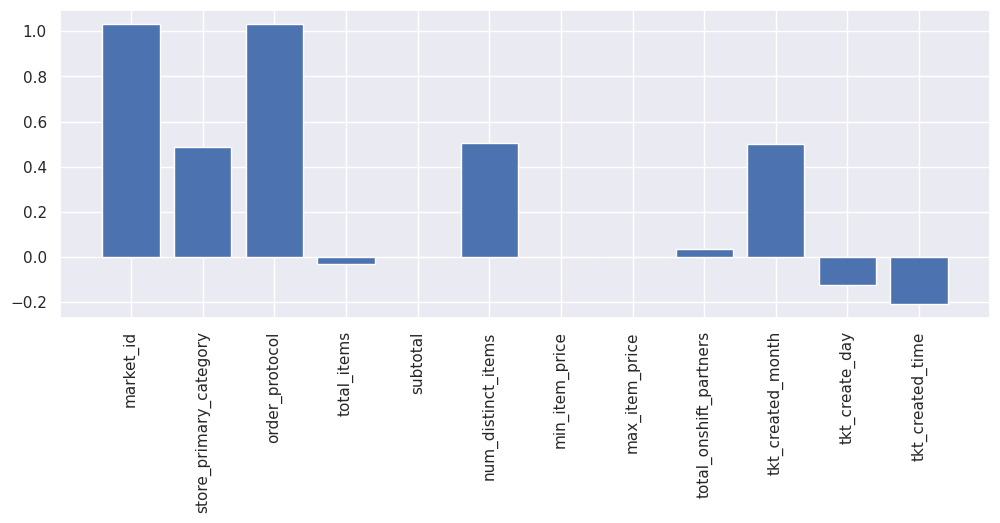

In [94]:
plt.figure(figsize=(12,4))
plt.bar(x = X_test.columns ,height=lr_model.coef_)
plt.xticks(rotation=90)
#plt.xticks([0,1,2,3,4,5,6,7,8,9],labels=X_test.columns,rotation=90)
plt.show()

<Figure size 900x600 with 0 Axes>

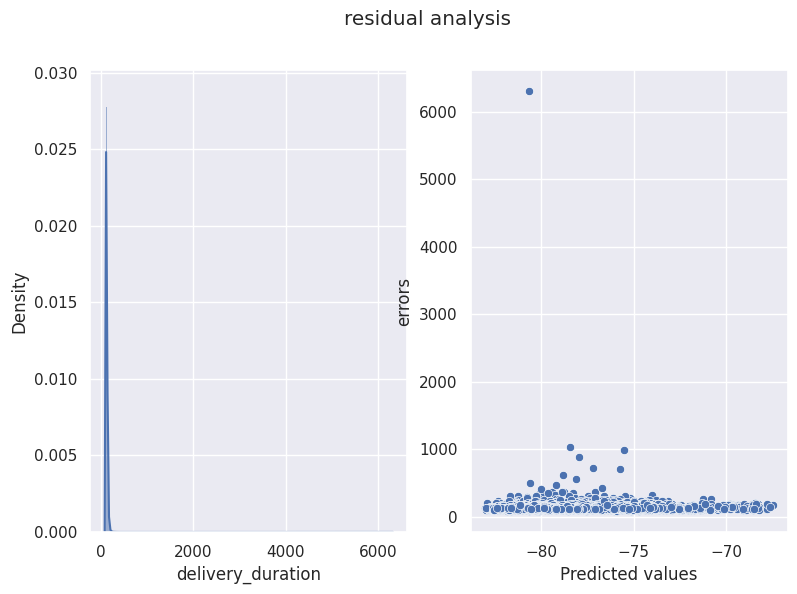

In [95]:
plt.tight_layout()
fig,(ax1,ax2)= plt.subplots(1,2)
sns.histplot(data=residual,kde=True,stat='density',ax=ax1)


sns.scatterplot(
    x=y_pred,
    y=residual,
    ax=ax2
)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("errors")

plt.suptitle('residual analysis')
fig.show()

`Inference`: mse for baseline model is 16930.071423824887

In [96]:
from sklearn.metrics import r2_score

In [97]:
# adjusted_r2 = 1 – [(1-R2)*(n-1)/(n-k-1)]
def adjusted_r2_score(score,num_of_observation,num_of_feature):
    return (1 - ( (   (1-score)*(num_of_observation-1) )   /(num_of_observation-num_of_feature-1) ))

In [98]:
score = r2_score(y_true=y_test,y_pred=y_pred)
score

-16.197133566008414

In [99]:
adjusted_r2_score(score=score,num_of_observation=X_test.shape[0],num_of_feature=X_test.shape[1])

-16.200302035750813

`Inference:` worst than mean model. and takeaway was non-linearity plays major role. We can introduce polynomial features in our model. I'll leave upto you the experiment and proceeding with RF and GDBT

### Model: RF Regression

In [100]:
r_df = df.drop([
    'created_at',
    'actual_delivery_time',
    'store_id',
    'tkt_created_year',
    'tkt_created_month',
    'tkt_deliver_day',
    'tkt_deliver_month','tkt_deliver_time','deliver_day_is_wekend',
    'tkt_deliver_year'
],axis=1)

X = r_df.drop('delivery_duration',axis=1)
y = r_df['delivery_duration']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)




# Encoder
encoder = TargetEncoder(verbose=1)
encode_rf_df = encoder.fit_transform(
    X_train[['market_id','store_primary_category','order_protocol','num_distinct_items']],
    y_train)


# Replacing- encoded values
X_train[['market_id','store_primary_category','order_protocol','num_distinct_items']] = encode_rf_df


# Eliminate Correlated Features- Correlation Heat MAP
X_train.drop(['total_busy_partners','total_outstanding_orders'],axis=1,inplace=True)



encoded_test_df = encoder.transform( X_test[['market_id','store_primary_category','order_protocol','num_distinct_items']])
X_test[['market_id','store_primary_category','order_protocol','num_distinct_items']] = encoded_test_df

X_test.drop(['total_busy_partners','total_outstanding_orders'],axis=1,inplace=True)

In [137]:
rfc = RandomForestRegressor(n_jobs=-1,verbose=1,oob_score=True)

In [138]:
params={
    "min_samples_split":[2,3],
    "n_estimators":[100,150,170],
    "max_depth":[90,100,120],
    "min_samples_leaf":[9,10,11]
}

clf = RandomizedSearchCV(estimator=rfc, param_distributions=params, scoring='neg_mean_squared_error', cv=5,n_iter=50)
clf

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, oob_score=True,
                                                   verbose=1),
                   n_iter=50,
                   param_distributions={'max_depth': [90, 100, 120],
                                        'min_samples_leaf': [9, 10, 11],
                                        'min_samples_split': [2, 3],
                                        'n_estimators': [100, 150, 170]},
                   scoring='neg_mean_squared_error')

best: #RandomForestRegressor(max_depth=100, min_samples_leaf=11, min_samples_split=3,
                      n_estimators=170, n_jobs=-1, oob_score=True, verbose=1)

#RandomForestRegressor(max_depth=90, min_samples_leaf=11, n_estimators=150,
                      n_jobs=-1, oob_score=True, verbose=1)

#RandomForestRegressor(max_depth=100, min_samples_leaf=10, min_samples_split=3,
                      n_estimators=150, n_jobs=-1, oob_score=True, verbose=1)

In [139]:
clf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:   25.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 170 out of 170 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:   24.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 170 out of 170 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]:

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, oob_score=True,
                                                   verbose=1),
                   n_iter=50,
                   param_distributions={'max_depth': [90, 100, 120],
                                        'min_samples_leaf': [9, 10, 11],
                                        'min_samples_split': [2, 3],
                                        'n_estimators': [100, 150, 170]},
                   scoring='neg_mean_squared_error')

In [140]:
print(clf.best_estimator_)
print( clf.best_score_)

pd.DataFrame(
    data=[clf.cv_results_['mean_test_score'],clf.cv_results_['params']]
).T.rename(columns={0:'mean_train_score', 1: 'parameters'})

RandomForestRegressor(max_depth=100, min_samples_leaf=11, min_samples_split=3,
                      n_estimators=170, n_jobs=-1, oob_score=True, verbose=1)
-505.72461462632435


,mean_train_score,parameters
0,-505.990911,"{'n_estimators': 170, 'min_samples_split': 3, ..."
1,-506.320667,"{'n_estimators': 150, 'min_samples_split': 3, ..."
2,-507.484577,"{'n_estimators': 170, 'min_samples_split': 3, ..."
3,-506.263744,"{'n_estimators': 150, 'min_samples_split': 2, ..."
4,-508.050602,"{'n_estimators': 100, 'min_samples_split': 3, ..."
5,-506.798765,"{'n_estimators': 150, 'min_samples_split': 2, ..."
6,-506.75985,"{'n_estimators': 100, 'min_samples_split': 2, ..."
7,-507.163526,"{'n_estimators': 170, 'min_samples_split': 3, ..."
8,-506.853894,"{'n_estimators': 150, 'min_samples_split': 3, ..."
9,-506.067913,"{'n_estimators': 170, 'min_samples_split': 2, ..."


In [101]:
rf = RandomForestRegressor(max_depth=100, min_samples_leaf=11, min_samples_split=3, n_estimators=170, n_jobs=-1, oob_score=True, verbose=1)
rf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:   22.3s finished


RandomForestRegressor(max_depth=100, min_samples_leaf=11, min_samples_split=3,
                      n_estimators=170, n_jobs=-1, oob_score=True, verbose=1)

In [102]:
y_pred = rf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 170 out of 170 | elapsed:    0.5s finished


In [103]:
print(f"mse: {mean_squared_error(y_true=y_test,y_pred=y_pred)}")

mse: 892.0780535740842


<Figure size 900x600 with 0 Axes>

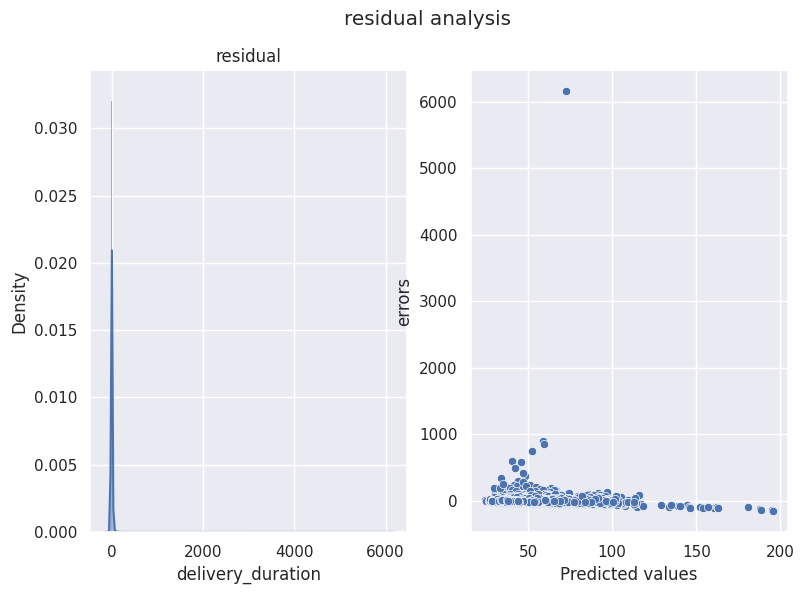

In [104]:
residual = y_test - y_pred
plt.tight_layout()
fig,(ax1,ax2)= plt.subplots(1,2)
sns.histplot(data=residual,kde=True,stat='density',ax=ax1)
ax1.set_title('residual')

sns.scatterplot(
    x=y_pred,
    y=residual,
    ax=ax2
)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("errors")

plt.suptitle('residual analysis')
fig.show()

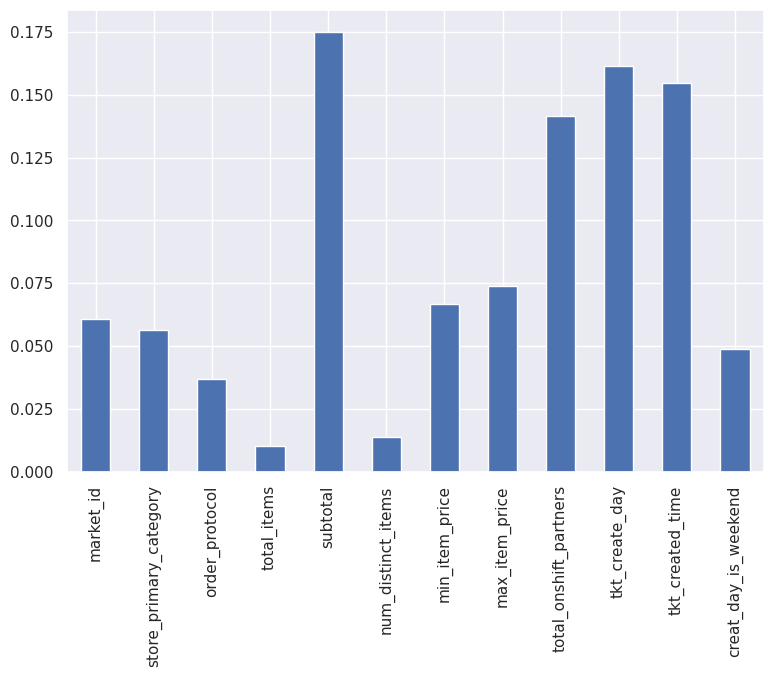

In [105]:
pd.Series(rf.feature_importances_).plot(kind="bar")
plt.xticks(range(rf.feature_importances_.shape[0]),labels=X_train.columns)
plt.show()

better than BaseLine model  RF-regressor: mse: 893.8407673820693

In [106]:
score = r2_score(y_true=y_test,y_pred=y_pred)
print(score)

adjusted_r2_score(score=score,num_of_observation=X_test.shape[0],num_of_feature=X_test.shape[1])

0.09384992806176762


0.09368297529176162

### Model: GBDT Regressor

In [107]:
gdbts = GradientBoostingRegressor(verbose=1)

In [108]:
params={
    "max_depth":[2,3],
    "n_estimators":[230,240,250,270],
}

clf = RandomizedSearchCV(estimator=gdbts, param_distributions=params, scoring='neg_mean_squared_error', cv=5,n_iter=50)
clf

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(verbose=1),
                   n_iter=50,
                   param_distributions={'max_depth': [2, 3],
                                        'n_estimators': [230, 240, 250, 270]},
                   scoring='neg_mean_squared_error')

#GradientBoostingRegressor(max_depth=2, n_estimators=250, verbose=1)

#GradientBoostingRegressor(max_depth=2, n_estimators=270, verbose=1)

In [148]:
clf.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1         362.5813           26.94s
         2         358.9627           26.97s
         3         355.8253           26.23s
         4         353.1624           25.77s
         5         350.9353           25.48s
         6         348.6879           25.23s
         7         346.8207           25.04s
         8         344.9832           24.88s
         9         343.4470           24.77s
        10         342.1099           24.61s
        20         330.6229           23.31s
        30         323.9960           21.47s
        40         319.4661           20.44s
        50         316.5049           19.34s
        60         313.3687           18.25s
        70         311.1690           17.34s
        80         308.8531           16.34s
        90         307.6415           15.34s
       100         306.3141           14.30s
       200         298.6310            3.30s
      Iter       Train Loss   Remaining Time 
        

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(verbose=1),
                   n_iter=50,
                   param_distributions={'max_depth': [2, 3],
                                        'n_estimators': [230, 240, 250, 270]},
                   scoring='neg_mean_squared_error')

In [149]:
print(clf.best_estimator_)
print( clf.best_score_)

pd.DataFrame(
    data=[clf.cv_results_['mean_test_score'],clf.cv_results_['params']]
).T.rename(columns={0:'mean_train_score', 1: 'parameters'})

GradientBoostingRegressor(n_estimators=240, verbose=1)
-519.5126243676153


,mean_train_score,parameters
0,-525.062881,"{'n_estimators': 230, 'max_depth': 2}"
1,-524.631296,"{'n_estimators': 240, 'max_depth': 2}"
2,-524.284021,"{'n_estimators': 250, 'max_depth': 2}"
3,-523.648945,"{'n_estimators': 270, 'max_depth': 2}"
4,-519.537066,"{'n_estimators': 230, 'max_depth': 3}"
5,-519.512624,"{'n_estimators': 240, 'max_depth': 3}"
6,-519.818648,"{'n_estimators': 250, 'max_depth': 3}"
7,-519.704651,"{'n_estimators': 270, 'max_depth': 3}"


In [156]:
clf.best_estimator_.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 240,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 1,
 'warm_start': False}

In [109]:
gdbt = GradientBoostingRegressor(n_estimators=240, verbose=1,loss='squared_error',max_depth=3)
gdbt.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1         587.9190           54.99s
         2         582.7299           48.30s
         3         578.6413           46.09s
         4         574.9307           44.65s
         5         571.9193           44.07s
         6         568.0227           43.30s
         7         564.9865           43.01s
         8         562.9736           42.52s
         9         560.9642           42.29s
        10         559.2679           41.86s
        20         545.9465           39.88s
        30         529.3669           38.05s
        40         523.3936           36.56s
        50         519.4522           34.79s
        60         516.4492           32.97s
        70         514.4268           31.26s
        80         512.2652           29.62s
        90         509.3773           27.94s
       100         507.5838           26.10s
       200         495.2319            7.30s


GradientBoostingRegressor(n_estimators=240, verbose=1)

In [110]:
y_pred = gdbt.predict(X_test)

In [111]:
residual = y_test - y_pred
print(f"mse: {mean_squared_error(y_true=y_test,y_pred=y_pred)}")

mse: 880.8007052373603


<Figure size 900x600 with 0 Axes>

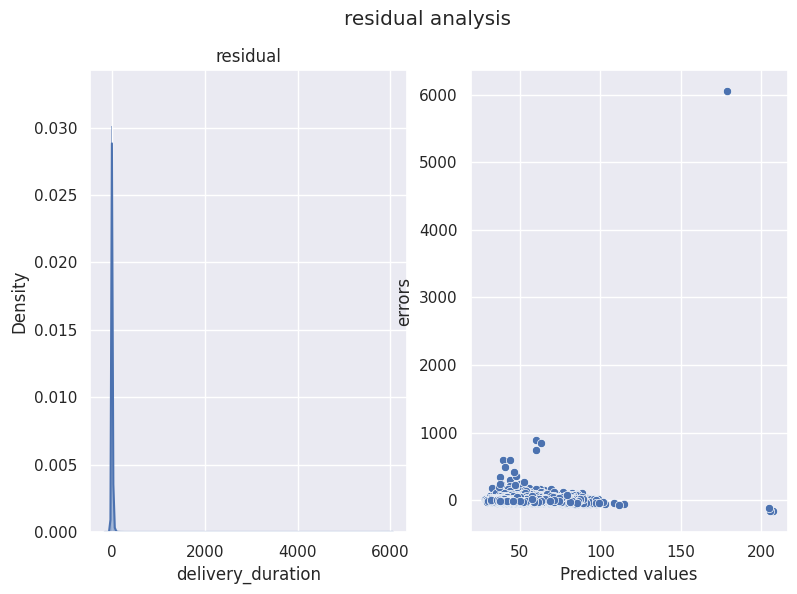

In [112]:
plt.tight_layout()
fig,(ax1,ax2)= plt.subplots(1,2)
sns.histplot(data=residual,kde=True,stat='density',ax=ax1)
ax1.set_title('residual')

sns.scatterplot(
    x=y_pred,
    y=residual,
    ax=ax2
)
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("errors")

plt.suptitle('residual analysis')
fig.show()

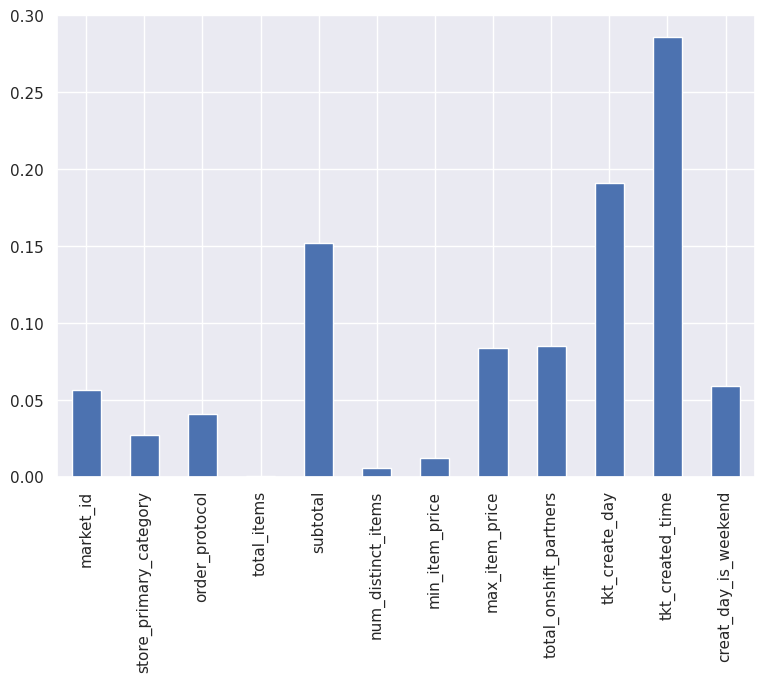

In [113]:

pd.Series(gdbt.feature_importances_).plot(kind="bar")
plt.xticks(range(rf.feature_importances_.shape[0]),labels=X_train.columns)
plt.show()

gdbt returns mse: 880.797041110597

<Figure size 900x600 with 0 Axes>

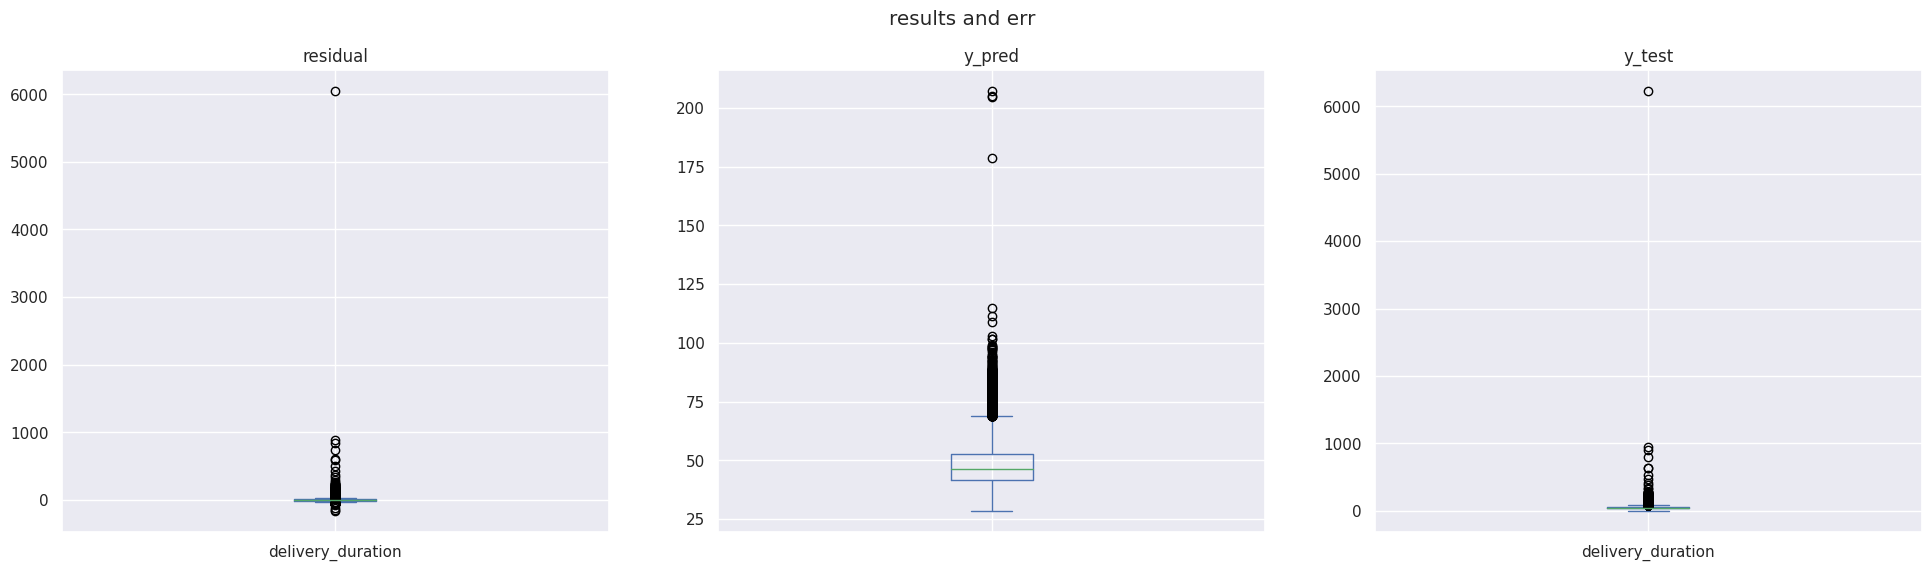

In [114]:

plt.tight_layout()
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,6))
residual.plot(kind="box",ax=ax1)
ax1.set_title("residual")

pd.Series(y_pred).plot(kind="box",ax=ax2)
ax2.set_title("y_pred")
fig.suptitle("results and err")

pd.Series(y_test).plot(kind="box",ax=ax3)
ax3.set_title("y_test")


plt.show()

In [115]:
score = r2_score(y_true=y_test,y_pred=y_pred)
print(score)

adjusted_r2_score(score=score,num_of_observation=X_test.shape[0],num_of_feature=X_test.shape[1])

0.1053051700842037


0.10514032787451877

**Confidence Interval**

In [160]:
residual.describe()

count    65144.000000
mean         0.079511
std         29.678346
min       -157.531772
25%        -10.578289
50%         -2.627512
75%          7.475968
max       6052.680403
Name: delivery_duration, dtype: float64

In [162]:
import scipy.stats as stats

In [167]:
stdev = np.sqrt(sum((y_pred - y_test)**2) / (len(y_test) - 1))

print(stdev)
prediction = pd.DataFrame()
prediction['true'] = y_pred




# alpha to critical
alpha = 0.2
n_sided = 2                                        # 2-sided test
z_crit = stats.norm.ppf(1-alpha/n_sided)
print(z_crit) # 1.959963984540054

prediction['worst-case'] = y_pred+(z_crit*stdev)


prediction

29.678452825040438
1.2815515655446004


,true,worst-case
0,40.734694,78.769162
1,36.498133,74.532601
2,45.235382,83.269850
3,44.909958,82.944426
4,56.070798,94.105266
...,...,...
65139,39.851387,77.885855
65140,45.241083,83.275551
65141,42.263917,80.298385
65142,37.572459,75.606927


worst-case if i'm okay to accept 20% error be acceptable and my C.I is 80%

`Note`: above timing is in minutes :)

In [116]:
# save the model to disk
filename = 'pickle_linear_regression_model.sav'
pickle.dump(lr_model, open(filename, 'wb'))


# save the model to disk
filename = 'pickle_rf_regression_model.sav'
pickle.dump(rf, open(filename, 'wb'))

# save the model to disk
filename = 'pickle_gdbt_regression_model.sav'
pickle.dump(gdbt, open(filename, 'wb'))


In [117]:
# load the model from disk
best_gbdt  = pickle.load(open('pickle_gdbt_regression_model.sav', 'rb'))
best_rf    = pickle.load(open('pickle_rf_regression_model.sav', 'rb'))
best_linear= pickle.load(open('pickle_linear_regression_model.sav', 'rb'))


# **DL Techniques**

In [118]:
import tensorflow as tf
#from tensorflow.keras  import layers,losses,optimizers,Sequential

2022-10-13 13:00:18.432442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 13:00:18.792609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 13:00:18.792633: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-13 13:00:18.840912: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-13 13:00:19.765169: W tensorflow/stream_executor/platform/de

In [119]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [120]:
from tensorflow.keras.utils import plot_model

In [121]:
df = pd.read_csv('./processed_df.csv',index_col='Unnamed: 0').sort_values(by='created_at')
df

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_duration,tkt_created_year,tkt_deliver_year,tkt_created_month,tkt_deliver_month,tkt_create_day,tkt_deliver_day,tkt_created_time,tkt_deliver_time,creat_day_is_weekend,deliver_day_is_wekend
43519,1.0,2015-01-21 15:22:03,2015-01-21 16:17:43,6a639c52538fd7bb3e1186724afbe9b2,dessert,4.0,2,1058,2,219,799,2.0,1.0,1.0,55.666667,2015,2015,1,1,21,21,15,16,False,False
148754,3.0,2015-01-21 15:31:51,2015-01-21 16:16:34,12fb63ba1566cb03484e1e5e290a73f4,cafe,4.0,2,690,2,195,255,2.0,0.0,1.0,44.716667,2015,2015,1,1,21,21,15,16,False,False
187014,1.0,2015-01-21 15:39:16,2015-01-21 15:58:11,f7cfdde9db36af8e0d9a6d123d5c385e,smoothie,4.0,3,1867,3,449,529,4.0,1.0,1.0,18.916667,2015,2015,1,1,21,21,15,15,False,False
10265,1.0,2015-01-21 15:40:42,2015-01-21 16:22:37,83f97f4825290be4cb794ec6a234595f,cafe,4.0,3,955,3,245,345,3.0,2.0,2.0,41.916667,2015,2015,1,1,21,21,15,16,False,False
188797,1.0,2015-01-21 15:41:33,2015-01-21 16:35:14,4195cac6ce8d484d041594a3faa2e13d,chinese,3.0,3,825,1,125,125,0.0,0.0,0.0,53.683333,2015,2015,1,1,21,21,15,16,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176616,6.0,2015-02-18 05:57:51,2015-02-18 06:38:38,d3e2e8f631bd9336ed25b8162aef8782,italian,4.0,3,3600,3,800,1500,36.0,35.0,43.0,40.783333,2015,2015,2,2,18,18,5,6,False,False
100474,2.0,2015-02-18 05:58:07,2015-02-18 06:16:03,e5522f7ac7cd76f19b396595c9c25b40,pasta,4.0,2,1800,2,825,975,13.0,9.0,8.0,17.933333,2015,2015,2,2,18,18,5,6,False,False
191692,6.0,2015-02-18 05:59:01,2015-02-18 06:33:53,c70cfa5c5ab75a16467bc95abaf5dc2a,fast,4.0,3,740,3,128,357,36.0,35.0,43.0,34.866667,2015,2015,2,2,18,18,5,6,False,False
168114,6.0,2015-02-18 05:59:23,2015-02-18 06:27:25,0fff885ae427e3adae25dbb31251470c,thai,3.0,1,1400,1,1200,1200,36.0,35.0,43.0,28.033333,2015,2015,2,2,18,18,5,6,False,False


In [122]:
df.drop(['created_at','actual_delivery_time','tkt_deliver_year','tkt_deliver_month','tkt_deliver_day','tkt_deliver_time','deliver_day_is_wekend'],axis=1,inplace=True)

In [123]:
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197406 entries, 43519 to 61787
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 197406 non-null  float64
 1   store_id                  197406 non-null  object 
 2   store_primary_category    197406 non-null  object 
 3   order_protocol            197406 non-null  float64
 4   total_items               197406 non-null  int64  
 5   subtotal                  197406 non-null  int64  
 6   num_distinct_items        197406 non-null  int64  
 7   min_item_price            197406 non-null  int64  
 8   max_item_price            197406 non-null  int64  
 9   total_onshift_partners    197406 non-null  float64
 10  total_busy_partners       197406 non-null  float64
 11  total_outstanding_orders  197406 non-null  float64
 12  delivery_duration         197406 non-null  float64
 13  tkt_created_year          197406 non-null

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_duration,tkt_created_year,tkt_created_month,tkt_create_day,tkt_created_time,creat_day_is_weekend
43519,1.0,6a639c52538fd7bb3e1186724afbe9b2,dessert,4.0,2,1058,2,219,799,2.0,1.0,1.0,55.666667,2015,1,21,15,False
148754,3.0,12fb63ba1566cb03484e1e5e290a73f4,cafe,4.0,2,690,2,195,255,2.0,0.0,1.0,44.716667,2015,1,21,15,False
187014,1.0,f7cfdde9db36af8e0d9a6d123d5c385e,smoothie,4.0,3,1867,3,449,529,4.0,1.0,1.0,18.916667,2015,1,21,15,False
10265,1.0,83f97f4825290be4cb794ec6a234595f,cafe,4.0,3,955,3,245,345,3.0,2.0,2.0,41.916667,2015,1,21,15,False
188797,1.0,4195cac6ce8d484d041594a3faa2e13d,chinese,3.0,3,825,1,125,125,0.0,0.0,0.0,53.683333,2015,1,21,15,False


In [124]:
X = df.drop('delivery_duration',axis=1)
y = df['delivery_duration']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Encoder
encoder = TargetEncoder(verbose=1)
encode_df = encoder.fit_transform(
    X_train[['market_id','store_id','store_primary_category','order_protocol','num_distinct_items']],
    y_train)


# Replacing- encoded values
X_train[['market_id','store_id','store_primary_category','order_protocol','num_distinct_items']] = encode_df


# Standization
std = StandardScaler()
X_train = pd.DataFrame(
      std.fit_transform(X_train),
      columns=X_train.columns
)

X_train

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,tkt_created_year,tkt_created_month,tkt_create_day,tkt_created_time,creat_day_is_weekend
0,-0.642218,-0.894340,-1.333894,1.410994,-0.436332,-0.335042,-0.413623,-0.069069,0.251803,-0.299785,-0.422058,-0.545168,0.0,-1.367942,1.268637,1.334525,-0.725530
1,0.669664,-1.483768,-1.479212,0.745128,0.289555,-0.900685,0.197679,-0.930726,-1.561949,-0.691583,-0.875247,-0.861227,0.0,0.731025,-0.359758,-0.976817,-0.725530
2,-0.642218,-0.893996,-1.278766,0.079262,-0.799276,-0.764359,-1.024925,0.255724,-0.869458,0.544089,1.325958,0.719069,0.0,-1.367942,1.051517,-0.861250,1.378303
3,0.669664,-1.745532,-1.232516,-1.252469,0.289555,0.558222,-0.413623,0.456331,-0.420953,-1.234074,-1.263695,-1.058764,0.0,-1.367942,0.617279,0.872256,-0.725530
4,-1.298159,1.645404,0.223242,-1.252469,-0.073389,1.099678,0.197679,0.781124,1.319244,-0.179232,-0.098351,-0.169848,0.0,0.731025,0.183040,-0.745683,-0.725530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132257,1.325605,0.007204,1.780832,-1.252469,2.104272,0.904534,2.031584,-0.833288,-0.654176,-0.812137,-0.972359,-0.762459,0.0,0.731025,-0.793997,-0.861250,1.378303
132258,0.669664,-0.451441,-0.287325,0.079262,-0.436332,-0.076683,-0.413623,0.313040,0.960440,2.503081,1.293587,1.588232,0.0,0.731025,-1.011116,-0.745683,-0.725530
132259,1.981546,-0.084147,0.200129,-1.252469,-0.073389,-0.733575,-0.413623,-0.498942,-1.183411,-0.239508,-0.195463,-0.268616,0.0,0.731025,-0.685437,-0.514549,-0.725530
132260,1.325605,-0.564798,-1.479212,0.745128,0.652498,-0.829773,1.420282,-1.083570,-1.274906,-0.932690,-1.004730,-0.940242,0.0,0.731025,-0.468318,1.565659,-0.725530


In [125]:
test_encode = encoder.transform(  X_test[['market_id','store_id','store_primary_category','order_protocol','num_distinct_items']] )
X_test[['market_id','store_id','store_primary_category','order_protocol','num_distinct_items']] = test_encode


X_test = std.transform(X_test)

In [126]:
X_train.to_csv('tf_train.csv')

In [127]:
pd.DataFrame(X_test,columns=X_train.columns).to_csv('tf_test.csv')

In [128]:
X_train

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,tkt_created_year,tkt_created_month,tkt_create_day,tkt_created_time,creat_day_is_weekend
0,-0.642218,-0.894340,-1.333894,1.410994,-0.436332,-0.335042,-0.413623,-0.069069,0.251803,-0.299785,-0.422058,-0.545168,0.0,-1.367942,1.268637,1.334525,-0.725530
1,0.669664,-1.483768,-1.479212,0.745128,0.289555,-0.900685,0.197679,-0.930726,-1.561949,-0.691583,-0.875247,-0.861227,0.0,0.731025,-0.359758,-0.976817,-0.725530
2,-0.642218,-0.893996,-1.278766,0.079262,-0.799276,-0.764359,-1.024925,0.255724,-0.869458,0.544089,1.325958,0.719069,0.0,-1.367942,1.051517,-0.861250,1.378303
3,0.669664,-1.745532,-1.232516,-1.252469,0.289555,0.558222,-0.413623,0.456331,-0.420953,-1.234074,-1.263695,-1.058764,0.0,-1.367942,0.617279,0.872256,-0.725530
4,-1.298159,1.645404,0.223242,-1.252469,-0.073389,1.099678,0.197679,0.781124,1.319244,-0.179232,-0.098351,-0.169848,0.0,0.731025,0.183040,-0.745683,-0.725530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132257,1.325605,0.007204,1.780832,-1.252469,2.104272,0.904534,2.031584,-0.833288,-0.654176,-0.812137,-0.972359,-0.762459,0.0,0.731025,-0.793997,-0.861250,1.378303
132258,0.669664,-0.451441,-0.287325,0.079262,-0.436332,-0.076683,-0.413623,0.313040,0.960440,2.503081,1.293587,1.588232,0.0,0.731025,-1.011116,-0.745683,-0.725530
132259,1.981546,-0.084147,0.200129,-1.252469,-0.073389,-0.733575,-0.413623,-0.498942,-1.183411,-0.239508,-0.195463,-0.268616,0.0,0.731025,-0.685437,-0.514549,-0.725530
132260,1.325605,-0.564798,-1.479212,0.745128,0.652498,-0.829773,1.420282,-1.083570,-1.274906,-0.932690,-1.004730,-0.940242,0.0,0.731025,-0.468318,1.565659,-0.725530


In [129]:
X_train.shape

(132262, 17)

In [130]:
pd.DataFrame(X_test,columns=X_train.columns)

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,tkt_created_year,tkt_created_month,tkt_create_day,tkt_created_time,creat_day_is_weekend
0,1.325605,-0.169551,-0.171308,0.745128,-0.073389,-0.376270,-0.413623,-1.024343,-0.420953,-0.751860,-0.810506,-0.742705,0.0,0.731025,-0.685437,1.565659,-0.725530
1,-0.642218,-1.110509,-1.333894,1.410994,-0.436332,-0.789645,-0.413623,-0.453089,-0.647000,0.785195,1.423070,0.185719,0.0,-1.367942,1.160077,-0.861250,-0.725530
2,0.669664,0.077978,1.080194,0.079262,-0.799276,-0.653869,-1.024925,1.545343,0.601637,1.779761,1.843888,1.924045,0.0,-1.367942,1.485756,-0.630116,-0.725530
3,1.325605,-0.686891,-1.181308,-1.252469,-0.799276,-0.981491,-1.024925,0.406657,-0.467598,-1.264212,-1.296066,-1.078518,0.0,0.731025,-0.793997,0.987823,1.378303
4,0.013723,0.017511,-0.008733,-0.586603,-0.436332,3.578829,-0.413623,4.038606,9.392325,-0.992967,-0.939989,-0.841474,0.0,-1.367942,1.051517,1.450092,1.378303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65139,-0.642218,-0.571535,-1.333894,-1.252469,-0.436332,-0.018414,-0.413623,1.232013,0.307418,-0.329923,-0.583911,-0.762459,0.0,0.731025,-0.251199,1.565659,-0.725530
65140,-0.642218,0.840411,1.278406,0.079262,-0.436332,0.462024,-0.413623,0.886204,0.610607,-0.360062,-0.519170,-0.564922,0.0,0.731025,-1.553915,1.565659,1.378303
65141,1.325605,0.182868,0.012801,1.410994,-0.799276,-1.063396,-1.024925,0.121985,-0.734907,0.092014,-0.583911,-0.446399,0.0,-1.367942,1.485756,-0.745683,-0.725530
65142,0.669664,-0.030767,-0.752975,-0.586603,-0.799276,-1.226108,-1.024925,-0.632681,-1.443544,-0.691583,-1.069471,-0.940242,0.0,-1.367942,1.485756,-0.976817,-0.725530


In [131]:
model1 = tf.keras.Sequential([
  tf.keras.layers.Dense(15,activation='relu'),
  tf.keras.layers.Dense(1,activation='relu')
])

model1.compile(loss=tf.keras.losses.mse, # mae is short for mean absolute error
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), # SGD is short for stochastic gradient descent
              metrics=["mse"])

history1 = model1.fit(X_train,y_train,epochs=50,verbose=1,workers=-1)

Epoch 1/50


2022-10-13 13:01:11.761671: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-13 13:01:11.761967: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-13 13:01:11.762006: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LinuxMint): /proc/driver/nvidia/version does not exist
2022-10-13 13:01:11.763150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4134/4134 [==============================] - 7s 2ms/step - loss: 2873.6721 - mse: 2873.6721
Epoch 2/50
4134/4134 [==============================] - 7s 2ms/step - loss: 2871.3342 - mse: 2871.3342
Epoch 3/50
4134/4134 [==============================] - 7s 2ms/step - loss: 2871.4443 - mse: 2871.4443
Epoch 4/50
4134/4134 [==============================] - 7s 2ms/step - loss: 2871.4434 - mse: 2871.4434
Epoch 5/50
4134/4134 [==============================] - 7s 2ms/step - loss: 2871.4399 - mse: 2871.4399
Epoch 6/50
4134/4134 [==============================] - 7s 2ms/step - loss: 2871.4373 - mse: 2871.4373
Epoch 7/50
4134/4134 [==============================] - 7s 2ms/step - loss: 2871.4438 - mse: 2871.4438
Epoch 8/50
4134/4134 [==============================] - 7s 2ms/step - loss: 2871.4426 - mse: 2871.4426
Epoch 9/50
4134/4134 [==============================] - 7s 2ms/step - loss: 2871.4431 - mse: 2871.4431
Epoch 10/50
4134/4134 [==============================] - 7s 2ms/step - loss: 2871.44

In [132]:
history1.history.keys()

dict_keys(['loss', 'mse'])

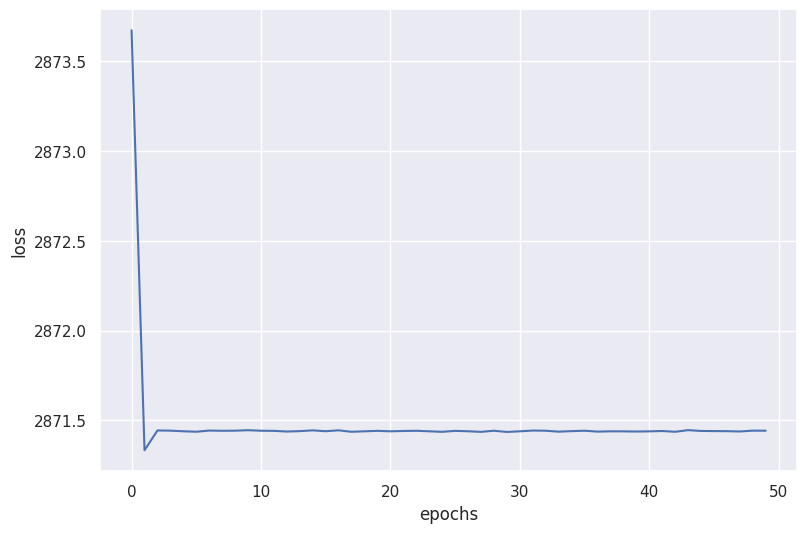

In [133]:
plt.plot(history1.history['loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

`Inference:` model1 not performing best but better than nothing

Let's try for learning_rate and Adam

In [134]:
y_pred = model1.predict(X_test)

2036/2036 [==============================] - 2s 1ms/step


In [135]:
mean_squared_error( y_true=y_test, y_pred= tf.squeeze( model1.predict(X_test) ) )

2036/2036 [==============================] - 2s 1ms/step


3270.94868811573

In [136]:
score = r2_score( y_true=y_test, y_pred= tf.squeeze( model1.predict(X_test) ) )
score

2036/2036 [==============================] - 2s 1ms/step


-2.317598032085281

In [137]:
adjusted_r2_score(score=score,num_of_observation=X_test.shape[0],num_of_feature=X_test.shape[1])

-2.318464032861399

tf model1 mse: 3270.94868811573 and adjusted_r2_score: -2.318464032861399

In [138]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Dense(15,activation='relu'),
  tf.keras.layers.Dense(1,activation='relu')
])

model2.compile(loss=tf.keras.losses.mse, # mse is short for mean absolute error
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), #Adam
              metrics=["mse"])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history2 = model2.fit(X_train,y_train,epochs=50,verbose=1,workers=6,callbacks=[lr_scheduler])

Epoch 1/50


2022-10-13 13:14:30.050351: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17987632 exceeds 10% of free system memory.


4134/4134 [==============================] - 8s 2ms/step - loss: 2468.8472 - mse: 2468.8472 - lr: 1.0000e-04
Epoch 2/50
4134/4134 [==============================] - 7s 2ms/step - loss: 1528.1105 - mse: 1528.1105 - lr: 1.1220e-04
Epoch 3/50
4134/4134 [==============================] - 7s 2ms/step - loss: 821.9279 - mse: 821.9279 - lr: 1.2589e-04
Epoch 4/50
4134/4134 [==============================] - 7s 2ms/step - loss: 630.5097 - mse: 630.5097 - lr: 1.4125e-04
Epoch 5/50
4134/4134 [==============================] - 7s 2ms/step - loss: 569.9905 - mse: 569.9905 - lr: 1.5849e-04
Epoch 6/50
4134/4134 [==============================] - 7s 2ms/step - loss: 538.8352 - mse: 538.8352 - lr: 1.7783e-04
Epoch 7/50
4134/4134 [==============================] - 7s 2ms/step - loss: 519.9543 - mse: 519.9543 - lr: 1.9953e-04
Epoch 8/50
4134/4134 [==============================] - 7s 2ms/step - loss: 504.8885 - mse: 504.8885 - lr: 2.2387e-04
Epoch 9/50
4134/4134 [==============================] - 7s 2ms/

In [139]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 15)                270       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 286
Trainable params: 286
Non-trainable params: 0
_________________________________________________________________


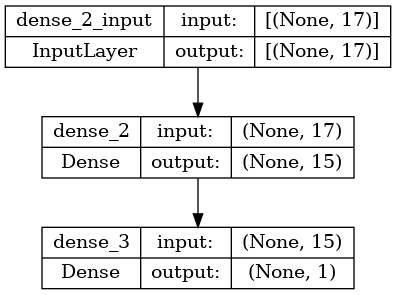

In [140]:
plot_model(model2, show_shapes=True)

In [141]:
history2.history.keys()

dict_keys(['loss', 'mse', 'lr'])

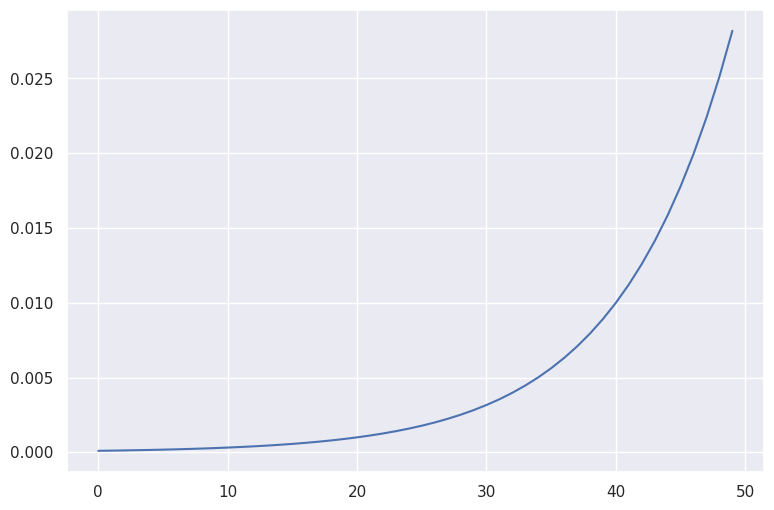

In [142]:
plt.plot(history2.history['lr'],label="learning rate")
plt.show()

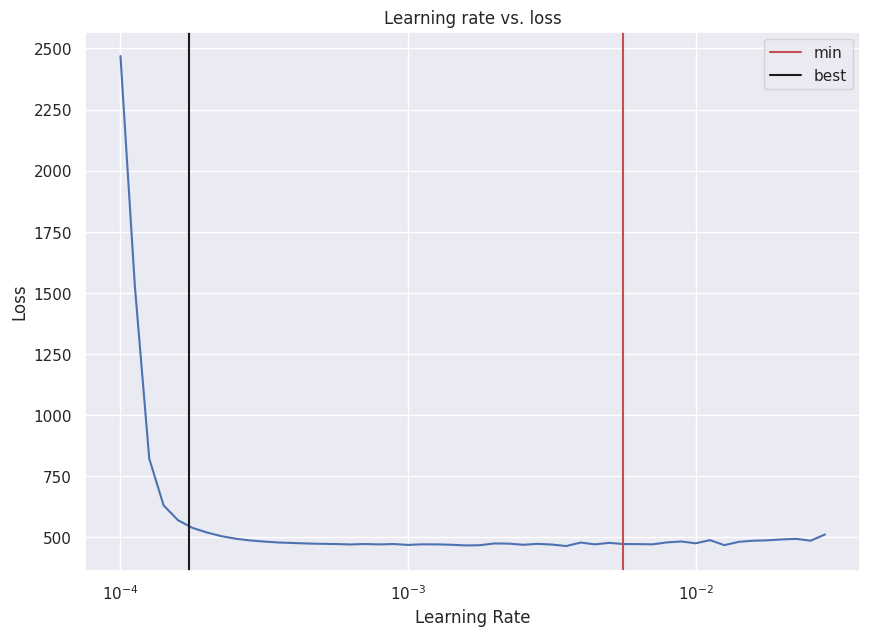

In [143]:
lrs = 1e-4 * (10 ** (np.arange(50)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history2.history["loss"]) # we want the x-axis (learning rate) to be log scale

plt.axvline(0.0056, color='r',label='min')
plt.axvline(0.00017347,color='k',label='best')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss")
plt.legend()
plt.show()

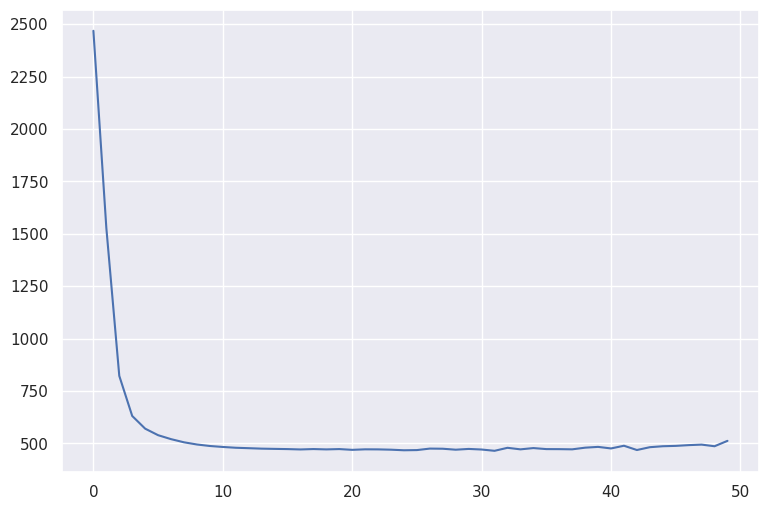

In [144]:
plt.plot(history2.history['loss'],label="losses")
plt.show()

In [145]:
mean_squared_error( y_true=y_test, y_pred= tf.squeeze( model2.predict(X_test) ) )

2036/2036 [==============================] - 2s 1ms/step


964.4724570870034

In [146]:
score = r2_score( y_true=y_test, y_pred= tf.squeeze( model2.predict(X_test) ) )
score

2036/2036 [==============================] - 3s 1ms/step


0.02177250983550505

In [147]:
adjusted_r2_score(score=score,num_of_observation=X_test.shape[0],num_of_feature=X_test.shape[1])

0.021517160707156924

model2 mse: and adjusted_r2_score: 

why best? significantly reducing before became flat line. It's good 


let's try different hyperparameter

In [148]:
model3 = tf.keras.Sequential([
  tf.keras.layers.Dense(50,activation='relu'),
  tf.keras.layers.Dense(13,activation='relu'),
  tf.keras.layers.Dense(1,activation='relu')
])

model3.compile(loss=tf.keras.losses.mse, # mse is short for mean absolute error
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00017347), #Adam
              metrics=["mse"])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history3 = model3.fit(X_train,y_train,epochs=100,verbose=1,workers=6,callbacks=[lr_scheduler])

Epoch 1/100


2022-10-13 13:20:42.807182: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17987632 exceeds 10% of free system memory.


4134/4134 [==============================] - 8s 2ms/step - loss: 1111.2009 - mse: 1111.2009 - lr: 1.0000e-04
Epoch 2/100
4134/4134 [==============================] - 8s 2ms/step - loss: 527.2875 - mse: 527.2875 - lr: 1.1220e-04
Epoch 3/100
4134/4134 [==============================] - 8s 2ms/step - loss: 498.0731 - mse: 498.0731 - lr: 1.2589e-04
Epoch 4/100
4134/4134 [==============================] - 8s 2ms/step - loss: 483.7871 - mse: 483.7871 - lr: 1.4125e-04
Epoch 5/100
4134/4134 [==============================] - 8s 2ms/step - loss: 477.2760 - mse: 477.2760 - lr: 1.5849e-04
Epoch 6/100
4134/4134 [==============================] - 8s 2ms/step - loss: 473.0574 - mse: 473.0574 - lr: 1.7783e-04
Epoch 7/100
4134/4134 [==============================] - 8s 2ms/step - loss: 469.5243 - mse: 469.5243 - lr: 1.9953e-04
Epoch 8/100
4134/4134 [==============================] - 8s 2ms/step - loss: 468.3636 - mse: 468.3636 - lr: 2.2387e-04
Epoch 9/100
4134/4134 [==============================] - 8

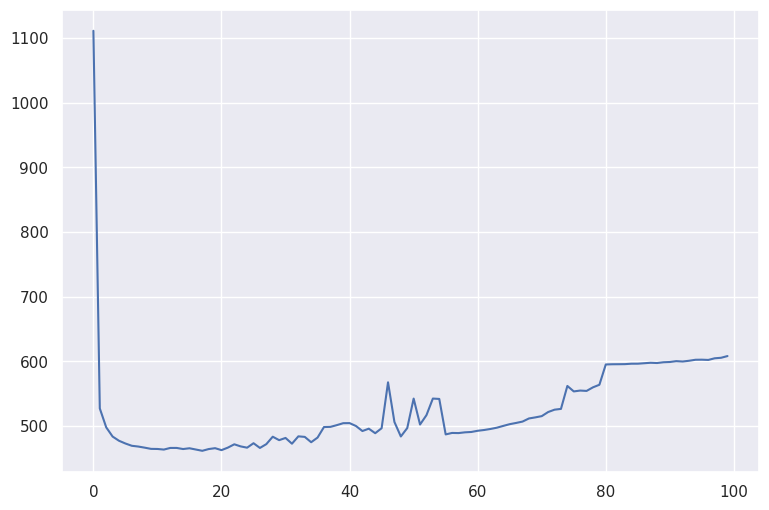

In [149]:
plt.plot(history3.history['loss'])
plt.show()

best: mse: 461.4293 - lr: 3.9811e-04

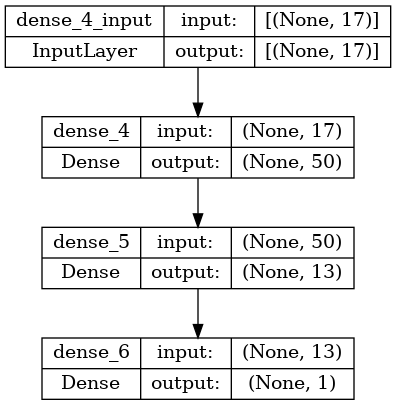

In [150]:
plot_model(model3, show_shapes=True)

In [151]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                900       
                                                                 
 dense_5 (Dense)             (None, 13)                663       
                                                                 
 dense_6 (Dense)             (None, 1)                 14        
                                                                 
Total params: 1,577
Trainable params: 1,577
Non-trainable params: 0
_________________________________________________________________


In [152]:
y_pred = model3.predict(X_test)

2036/2036 [==============================] - 3s 1ms/step


In [153]:
y_pred.ndim

2

In [154]:
y_pred = tf.squeeze(y_pred)

In [155]:
mean_squared_error(y_true=y_test,y_pred=y_pred)

989.1081119444208

In [156]:
mean_squared_error( y_true=y_test, y_pred= tf.squeeze( model3.predict(X_test) ) )

2036/2036 [==============================] - 3s 1ms/step


989.1081119444208

In [157]:
score = r2_score( y_true=y_test, y_pred= tf.squeeze( model3.predict(X_test) ) )
score

2036/2036 [==============================] - 3s 1ms/step


-0.003214491755517246

In [158]:
adjusted_r2_score(score=score,num_of_observation=X_test.shape[0],num_of_feature=X_test.shape[1])

-0.0034763633023624507

model2 gives mse of 901 but model3 gives 991 slightly overfitted

In [159]:
model4 = tf.keras.Sequential([
  tf.keras.layers.Dense(20,activation='relu'),
  tf.keras.layers.Dense(12,activation='relu'),
  tf.keras.layers.Dense(1,activation='relu')
])

model4.compile(loss=tf.keras.losses.huber, # mse is short for mean absolute error
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00017347), #Adam
              metrics=["mse"])

history4 = model4.fit(X_train,y_train,epochs=100,verbose=1,workers=6)

Epoch 1/100


2022-10-13 13:34:36.636665: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17987632 exceeds 10% of free system memory.


4134/4134 [==============================] - 10s 2ms/step - loss: 20.3417 - mse: 1067.0765
Epoch 2/100
4134/4134 [==============================] - 8s 2ms/step - loss: 11.4729 - mse: 508.9508
Epoch 3/100
4134/4134 [==============================] - 8s 2ms/step - loss: 11.0368 - mse: 491.0010
Epoch 4/100
4134/4134 [==============================] - 8s 2ms/step - loss: 10.8523 - mse: 483.2090
Epoch 5/100
4134/4134 [==============================] - 8s 2ms/step - loss: 10.7559 - mse: 478.0760
Epoch 6/100
4134/4134 [==============================] - 8s 2ms/step - loss: 10.6994 - mse: 474.3951
Epoch 7/100
4134/4134 [==============================] - 8s 2ms/step - loss: 10.6628 - mse: 474.2018
Epoch 8/100
4134/4134 [==============================] - 8s 2ms/step - loss: 10.6392 - mse: 472.5665
Epoch 9/100
4134/4134 [==============================] - 8s 2ms/step - loss: 10.6203 - mse: 471.5049
Epoch 10/100
4134/4134 [==============================] - 8s 2ms/step - loss: 10.6050 - mse: 471.1121

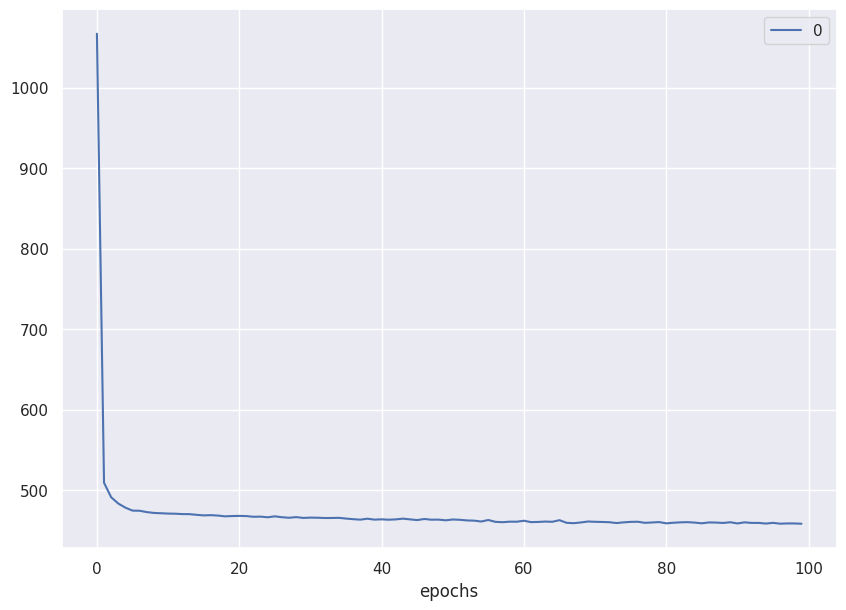

In [160]:
pd.DataFrame(history4.history['mse']).plot(figsize=(10,7), xlabel="epochs");

In [161]:
mean_squared_error( y_true=y_test, y_pred= tf.squeeze( model4.predict(X_test) ) )

2036/2036 [==============================] - 2s 1ms/step


947.3685630533312

In [135]:
mean_squared_error( y_true=y_test, y_pred= tf.squeeze( model4.predict(X_test) ) )

2036/2036 [==============================] - 2s 1ms/step


3270.94868811573

In [162]:
score = r2_score( y_true=y_test, y_pred= tf.squeeze( model4.predict(X_test) ) )
score

2036/2036 [==============================] - 2s 1ms/step


0.03912033476264998

In [163]:
adjusted_r2_score(score=score,num_of_observation=X_test.shape[0],num_of_feature=X_test.shape[1])

0.03886951397972105

In [164]:
model5 = tf.keras.Sequential([
  tf.keras.layers.Dense(15,activation='relu'),
  tf.keras.layers.Dense(1,activation='relu')
])

model5.compile(loss=tf.keras.losses.mse, # mse is short for mean absolute error
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), #Adam
              metrics=["mse"])


history5 = model5.fit(X_train,y_train,epochs=100,verbose=1,workers=6)

Epoch 1/100


2022-10-13 13:48:39.132039: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17987632 exceeds 10% of free system memory.


4134/4134 [==============================] - 7s 2ms/step - loss: 507.4231 - mse: 507.4231
Epoch 2/100
4134/4134 [==============================] - 7s 2ms/step - loss: 513.4554 - mse: 513.4554
Epoch 3/100
4134/4134 [==============================] - 7s 2ms/step - loss: 495.5828 - mse: 495.5828
Epoch 4/100
4134/4134 [==============================] - 7s 2ms/step - loss: 491.6237 - mse: 491.6237
Epoch 5/100
4134/4134 [==============================] - 7s 2ms/step - loss: 490.4618 - mse: 490.4618
Epoch 6/100
4134/4134 [==============================] - 7s 2ms/step - loss: 498.0546 - mse: 498.0546
Epoch 7/100
4134/4134 [==============================] - 7s 2ms/step - loss: 490.1680 - mse: 490.1680
Epoch 8/100
4134/4134 [==============================] - 7s 2ms/step - loss: 524.0787 - mse: 524.0787
Epoch 9/100
4134/4134 [==============================] - 7s 2ms/step - loss: 489.4995 - mse: 489.4995
Epoch 10/100
4134/4134 [==============================] - 7s 2ms/step - loss: 490.2793 - mse: 

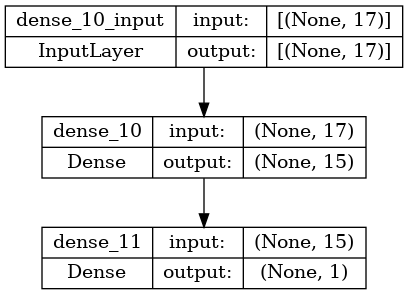

In [165]:
plot_model(model5, show_shapes=True)

In [166]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 15)                270       
                                                                 
 dense_11 (Dense)            (None, 1)                 16        
                                                                 
Total params: 286
Trainable params: 286
Non-trainable params: 0
_________________________________________________________________


In [167]:
mean_squared_error( y_true=y_test, y_pred= tf.squeeze( model5.predict(X_test) ) )

2036/2036 [==============================] - 2s 1ms/step


907.983371069309

In [168]:
score = r2_score( y_true=y_test, y_pred= tf.squeeze( model5.predict(X_test) ) )
score

2036/2036 [==============================] - 2s 1ms/step


0.07906722720221426

In [169]:
adjusted_r2_score(score=score,num_of_observation=X_test.shape[0],num_of_feature=X_test.shape[1])

0.0788268338548942

`Overfitted more :(`

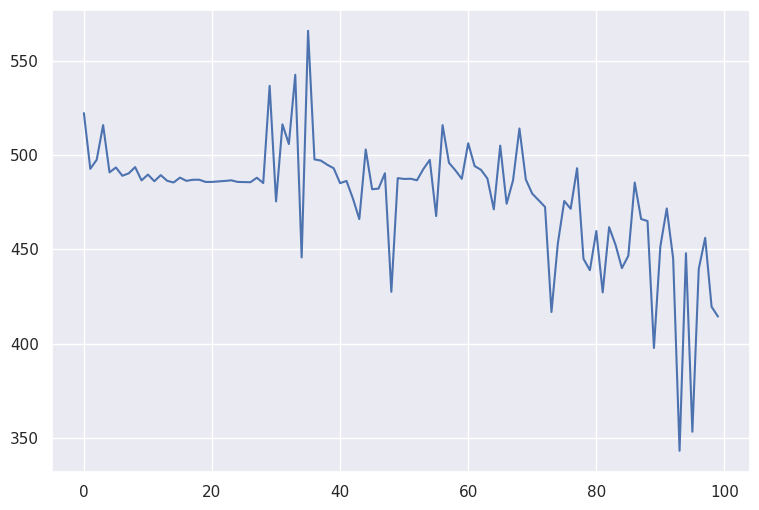

In [98]:
plt.plot(history5.history['loss'])
plt.show()

In [171]:
model6 = tf.keras.Sequential([
  tf.keras.layers.Dense(15,activation='relu'),
  tf.keras.layers.Dense(1,activation='relu')
])

model6.compile(loss=tf.keras.losses.huber, # mse is short for mean absolute error
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), #Adam
              metrics=["mse"])


history6 = model6.fit(X_train,y_train,epochs=50,verbose=1,workers=6)

Epoch 1/50


2022-10-13 14:00:09.238206: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17987632 exceeds 10% of free system memory.


4134/4134 [==============================] - 8s 2ms/step - loss: 11.1496 - mse: 498.9327
Epoch 2/50
4134/4134 [==============================] - 7s 2ms/step - loss: 10.6552 - mse: 477.2792
Epoch 3/50
4134/4134 [==============================] - 7s 2ms/step - loss: 10.5883 - mse: 470.9606
Epoch 4/50
4134/4134 [==============================] - 8s 2ms/step - loss: 10.5276 - mse: 496.7420
Epoch 5/50
4134/4134 [==============================] - 7s 2ms/step - loss: 10.5048 - mse: 487.8171
Epoch 6/50
4134/4134 [==============================] - 7s 2ms/step - loss: 10.4820 - mse: 494.7875
Epoch 7/50
4134/4134 [==============================] - 7s 2ms/step - loss: 10.4605 - mse: 493.4960
Epoch 8/50
4134/4134 [==============================] - 7s 2ms/step - loss: 10.4450 - mse: 492.3490
Epoch 9/50
4134/4134 [==============================] - 7s 2ms/step - loss: 10.4248 - mse: 492.6518
Epoch 10/50
4134/4134 [==============================] - 7s 2ms/step - loss: 10.4213 - mse: 491.7627
Epoch 11/5

In [172]:
mean_squared_error( y_true=y_test, y_pred= tf.squeeze( model6.predict(X_test) ) )

2036/2036 [==============================] - 2s 1ms/step


902.4955973140794

In [173]:
score = r2_score( y_true=y_test, y_pred= tf.squeeze( model6.predict(X_test) ) )
score

2036/2036 [==============================] - 2s 1ms/step


0.08463326603279175

In [174]:
adjusted_r2_score(score=score,num_of_observation=X_test.shape[0],num_of_feature=X_test.shape[1])

0.0843943256022811

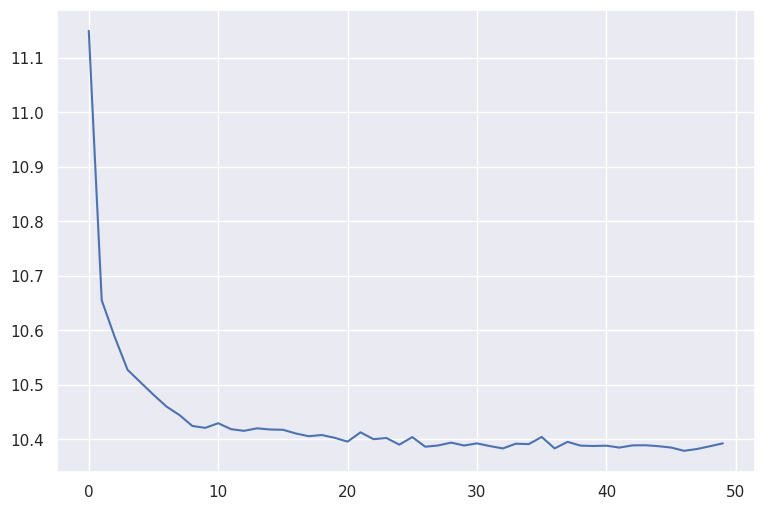

In [175]:
plt.plot(history6.history['loss'])
plt.show()

In [176]:
model7 = tf.keras.Sequential([
  tf.keras.layers.Dense(15,activation='relu'),
  tf.keras.layers.Dense(1,activation='relu')
])

model7.compile(loss=tf.keras.losses.huber, # mse is short for mean absolute error
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), #Adam
              metrics=["mse"])


history7 = model7.fit(X_train,y_train,epochs=60,verbose=1,workers=8)

Epoch 1/60
4134/4134 [==============================] - 8s 2ms/step - loss: 11.1198 - mse: 494.1407
Epoch 2/60
4134/4134 [==============================] - 8s 2ms/step - loss: 10.6558 - mse: 462.8940
Epoch 3/60
4134/4134 [==============================] - 9s 2ms/step - loss: 10.5685 - mse: 493.3819
Epoch 4/60
4134/4134 [==============================] - 8s 2ms/step - loss: 10.5255 - mse: 496.1056
Epoch 5/60
4134/4134 [==============================] - 8s 2ms/step - loss: 10.5068 - mse: 495.3492
Epoch 6/60
4134/4134 [==============================] - 8s 2ms/step - loss: 10.4674 - mse: 464.4372
Epoch 7/60
4134/4134 [==============================] - 8s 2ms/step - loss: 10.4487 - mse: 493.2424
Epoch 8/60
4134/4134 [==============================] - 9s 2ms/step - loss: 10.4453 - mse: 495.3610
Epoch 9/60
4134/4134 [==============================] - 8s 2ms/step - loss: 10.4342 - mse: 491.7688
Epoch 10/60
4134/4134 [==============================] - 7s 2ms/step - loss: 10.4294 - mse: 491.9142

In [177]:
mean_squared_error( y_true=y_test, y_pred= tf.squeeze( model7.predict(X_test) ) )

2036/2036 [==============================] - 2s 981us/step


960.5652711305084

In [178]:
score = r2_score( y_true=y_test, y_pred= tf.squeeze( model7.predict(X_test) ) )
score

2036/2036 [==============================] - 2s 992us/step


0.025735418971730595

In [179]:
adjusted_r2_score(score=score,num_of_observation=X_test.shape[0],num_of_feature=X_test.shape[1])

0.02548110429130368

Model Observation:
---


linear: mse: 16930.071423824887 r2: -16.197133566008414

RF    : mse: 892.0780535740842  r2: 0.09384992806176762

gdbt  : mse: 880.797041110597   r2: 0.10514032787451877

model1:  3270.94868811573, -2.317598032085281

model2:  964.4724570870034, 0.021517160707156924

model3:  989.1081119444208, -0.0034763633023624507

model4:  3270.94868811573,   0.03886951397972105

model5:  907.983371069309, 0.0788268338548942

model6:  902.4955973140794, 0.084633266

model7:  960.5652711305084,  0.025481104


**`TAKE AWAY:`**  Deep Learning may be good with Unstructed data. but here closely with structured model. But gbdt and RF perform better in structured data

As per occam razer principle pick simple and generaliable model rather than complex and non-interpretable